# 作業1 : 辨識名畫的作者

資料集: [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

程式碼參考自: [Tensorflow](https://www.tensorflow.org/)

> **資料集說明**

After being challenged many times by my girlfriend about who is the best to guess the painter, I decided to use the power of machine learning to defeat her.I gathered a collection of artworks of the 50 most influential artists of all time.

請幫幫資料集作者完成他女朋友的挑戰。**訓練一個CNN模型輸入是一張畫作，辨識出這張畫可能是哪個畫家的作品。**


>**作業說明**

**第一步驟**: 左上角 檔案->在雲端硬碟建立副本。

**第二步驟**: 右上角 共用->取得連結->任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段->更變執行類型->GPU。 可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉

請 **隨意修改** 這個colab的程式來完成訓練CNN模型。**只要跑得出來Testing Accuracy、Loss; 1~7個作業項目即可**，不必一定要照著todo提示走。
繳交時記得改檔案標題的學號。

本次作業著重在前處理，現實中很多筆資料的label不見得會直接給你，很多都會在奇怪的位置，例如本次作業，label隱藏在圖片名稱之中。你需要做很多前處理來提取標籤。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看test data
2. 模型請手刻、手疊，**不要用Transfer Learning**來引入ResNet、Inception...等知名模型來增加準確率。
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存output結果，更改**檔名學號**，左上角 檔案->下載 成ipynb檔。
2. 交一個pdf檔，裡面需要附上**你的作業colab連結(設為可編輯)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 文件內至少應貼上你的Test Acc
4. 上述兩個檔案繳交至ee-class。

> **繳交期限**

1. 電子商務技術(IM5002): 期限至2022/5/2(一) 23:59分
2. 人工智慧與機器學習(IM3078): 期限至2022/5/2(一) 23:59分
3. 電子商務智慧技術(IMA0200): 期限至2022/4/23(六) 23:59分

> **算分標準**

20 + Test_Acc + Predict function(10分) + 20分文件
1. 20分免費送
2. Test_Acc
3. preditAuthor有寫出來就10分(第七段)
4. 20分是文件分數

有問題再來信助教: ncuzhonghuan@g.ncu.edu.tw

### 資料集下載

- 資料集說明 : 
  - artists.csv : dataset of information for each artist
  - train_resized/ : image dataset of training paintings. Image name contain image author's name.
  - test_resized/ : image dataset of testing paintings. Image name contain image author's name.
  - 詳細內容可以下載完點擊colab左側**檔案**來查看

In [ ]:
import random
import os 

# 大家盡量先把資料保存在本地端，然後要訓練時用本地端上傳做訓練
# 以節省學術網路資源，避免IP被封鎖

if(os.path.isfile("./train.zip") == False):
  !wget -O train.zip "http://140.115.83.111/files/art/train.zip"
  !wget -O test.zip "http://140.115.83.111/files/art/test.zip"
  !echo "分流1"
  !unzip train.zip
  !unzip test.zip 
else:
  !echo "檔案已存在"

串流輸出內容已截斷至最後 5000 行。
  inflating: train_resized/Joan_Miro_27.jpg  
  inflating: train_resized/Joan_Miro_28.jpg  
  inflating: train_resized/Joan_Miro_29.jpg  
  inflating: train_resized/Joan_Miro_3.jpg  
  inflating: train_resized/Joan_Miro_30.jpg  
  inflating: train_resized/Joan_Miro_31.jpg  
  inflating: train_resized/Joan_Miro_32.jpg  
  inflating: train_resized/Joan_Miro_33.jpg  
  inflating: train_resized/Joan_Miro_34.jpg  
  inflating: train_resized/Joan_Miro_35.jpg  
  inflating: train_resized/Joan_Miro_36.jpg  
  inflating: train_resized/Joan_Miro_37.jpg  
  inflating: train_resized/Joan_Miro_39.jpg  
  inflating: train_resized/Joan_Miro_4.jpg  
  inflating: train_resized/Joan_Miro_40.jpg  
  inflating: train_resized/Joan_Miro_42.jpg  
  inflating: train_resized/Joan_Miro_43.jpg  
  inflating: train_resized/Joan_Miro_44.jpg  
  inflating: train_resized/Joan_Miro_45.jpg  
  inflating: train_resized/Joan_Miro_46.jpg  
  inflating: train_resized/Joan_Miro_47.jpg  
  inflating: tr

## 1. 讀入封包

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D

## 2. 取得資料集

- **我們來檢視一下artist.csv**，重要內容包含:
  - 畫家名稱(name)
  - 風格 (genre)
  - 資料集內畫作數量 (paintings)

總共有50位畫家，意味者有50個class要去辨識。

In [ ]:
train_dir = "./train_resized/"
test_dir = "./test_resized/"
artists = pd.read_csv("./artists.csv")
num_classes = artists.shape[0]
print("Number of artists : ",num_classes)
artists.head()

Number of artists :  50


,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: ?а?и?...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod m?n?]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [??ne...,http://en.wikipedia.org/wiki/René_Magritte,194


* 只取出名字與畫的數量，把名字用下底線連起來

In [ ]:
artists = artists.loc[:,["name","paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
artists['class_weight'] = artists.paintings.sum() / (artists.shape[0] * artists.paintings)

class_weight = artists['class_weight'].to_dict()
artists.head()

,name,paintings,class_weight
0,Amedeo_Modigliani,193,0.875233
1,Vasiliy_Kandinskiy,88,1.919545
2,Diego_Rivera,70,2.413143
3,Claude_Monet,73,2.313973
4,Rene_Magritte,194,0.870722


* **計算各個畫家畫作數量**
* 每個class資料的不平衡容易引響模型的訓練，學生可以嘗試解決這個問題。(提示: keras的class_weight)

可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。
最多畫作為 :  877  最少畫作為 :  24


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


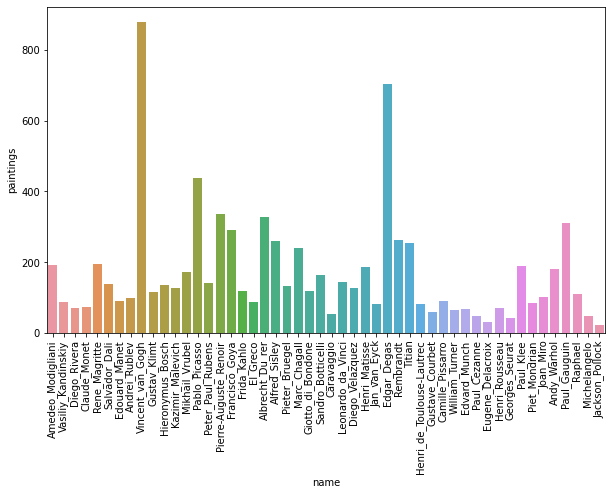

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 6))
barplot = sns.barplot(artists.name,artists.paintings)
for item in barplot.get_xticklabels():
    item.set_rotation(90)
    
print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ",artists.paintings.max()," 最少畫作為 : ",artists.paintings.min())

* 隨機讀取畫作來看看

training 畫作總共畫作有 :  7520


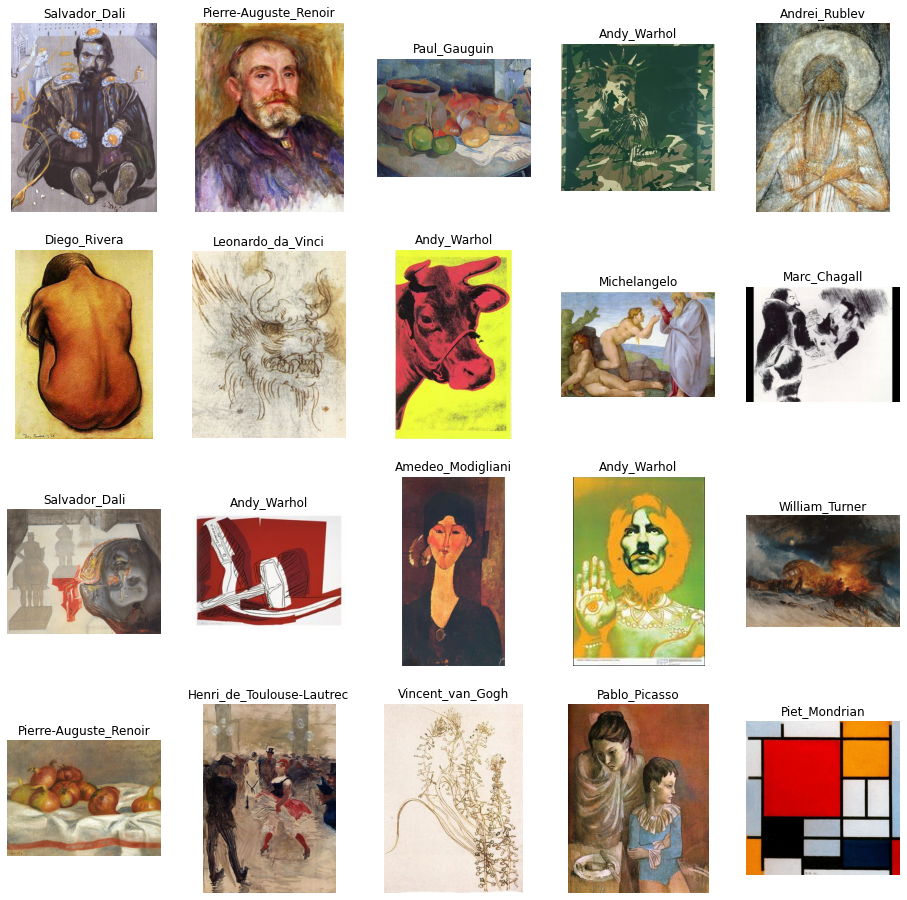

In [ ]:
img_list = os.listdir(train_dir)
total_len = len(img_list)
randomlist = random.sample(range(0,total_len), 20)
print("training 畫作總共畫作有 : ",total_len)

show_imgs = [img_list[rand] for rand in randomlist]

plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
    imgpath = train_dir+imgName
    img = cv.imread(imgpath)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.subplot(4,5,index+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))

## 3. 資料前處理

**有幾個重要的點需要處理**
1. 我們現在只有各個畫的路徑。Ex: /content/train_resized/Claude_Monet_22.jpg 。要取出label : Claude_Monet
2. label(作者名稱)是英文，我們要先把英文映射成數字。EX: Van_Gogh --> 0 ; Edvard_Munch --> 1
3. label數字還要轉乘 50 depth的one_hot
4. 現在有畫的路徑了，要讀取圖片
5. 每張圖片的大小不一樣，要統一大小才能輸入模型
6. 把每張圖片正規化，映射到[0,1]之間
7. 路徑是按照作者名稱排列的，太整齊了，把資料集打散(shuffle)。
8. 如果有需要，拆分成訓練用資料(training_data)、驗證用(validation_data)
9. **重要!** 確定好你資料input output的維度，才能開始建立模型。EX: input:(256,256,3); output:(50,)

**助教推薦一個好用的工具** from_tensor_slices [參考](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

* from_tensor_slices 可以輕鬆的讀取想要的資料，把圖片路徑傳入tensor後用map將路徑轉成圖片檔案。

* **以下程式todo只是提供程式思路，你完全可以不理他，反正test結果能出來就好。**



In [ ]:
# 請建立將英文映射成數字的dict。EX: Van_Gogh --> 0

author_Dict = dict()

def make_Authordict():
  index = 0
  for i in artists["name"]:
    author_Dict[i] = index
    index = index+1
  return author_Dict

class_name = make_Authordict()

# 請建立將數字映射成英文的dict。 EX: 0 --> Van_Gogh
rev_class_name = {v: k for k, v in author_Dict.items()}

In [ ]:
def get_label(picName):
  # 請取出label並轉成數字
  # EX: Claude_Monet_1.jpg -> Claude_Monet -> 1
  baseline = "_"
  picName = picName.rpartition(baseline)[0]
  return author_Dict[picName]

def get_path(dir,picName):
  # 請將路徑合併
  # EX: ./train_resized/ + Claude_Monet_1.jpg => ./train_resized/Claude_Monet_1.jpg
  path = dir + picName
  return path

def make_paths_label(dir):
  img_list = os.listdir(dir)
  paths = []
  labels = []
  
  # 將preprocess完成的path、label用for迴圈放入paths和labels
  for img in img_list:
    labels.append(get_label(img))
    paths.append(get_path(dir,img))
    onehot_labels = np.eye(50)[labels]
  return paths,onehot_labels
  # 將labels轉成onehot


In [ ]:
# 來查看一下
paths,onehot_labels = make_paths_label(train_dir)

print("paths : ")
for p in paths[:5]:
  print(p)
print("-"*20)
print("labels : ")
for label in onehot_labels[:5]:
  print(label)

paths : 
./train_resized/Paul_Gauguin_139.jpg
./train_resized/Francisco_Goya_135.jpg
./train_resized/Pierre-Auguste_Renoir_202.jpg
./train_resized/Paul_Klee_147.jpg
./train_resized/Marc_Chagall_9.jpg
--------------------
labels : 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

In [ ]:
# 轉成tensorflow dataset格式，變成路徑tensor
# 這個只是from_tensor_slices範例
paths_ds = tf.data.Dataset.from_tensor_slices(paths)
train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

print("turn to tensor")
for tensor in paths_ds.take(5):
  print(tensor)

turn to tensor
tf.Tensor(b'./train_resized/Paul_Gauguin_139.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Francisco_Goya_135.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Pierre-Auguste_Renoir_202.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Paul_Klee_147.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Marc_Chagall_9.jpg', shape=(), dtype=string)


In [ ]:
# 決定你輸入模型的圖片長寬
# shuffle buffle size
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_SIZE = ((IMG_WIDTH),(IMG_HEIGHT))
shuffle_buffer = 2000

def get_image(path):
  # read image from path
  file = tf.io.read_file(path)
  img = tf.io.decode_jpeg(file,channels=3)
  img = tf.image.convert_image_dtype(img, dtype=np.float32)
  # 請固定每張圖片大小為IMG_HEIGHT、IMG_WIDTH
  # 並將圖片每個pixel映射到[0,1]之間
  img = tf.image.resize(img, IMG_SIZE)
  return img

# 將所有資料轉成Tensor -> Tensor 轉成圖片
# 圖片Tensor 與 label Tensor Zip起來成一個pair
# shuffle打散
def make_dataset(dir):
  paths,onehot_labels = make_paths_label(dir)
  paths_ds = tf.data.Dataset.from_tensor_slices(paths)
  train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

  # 將路徑tensor映射成圖片tensor 
  train_image = paths_ds.map(get_image)
  # 合併圖片與label資料集
  full_ds = tf.data.Dataset.zip((train_image,train_label))
  # 打散
  full_ds = full_ds.shuffle(shuffle_buffer,reshuffle_each_iteration=False)
  return full_ds

full_ds = make_dataset(train_dir)

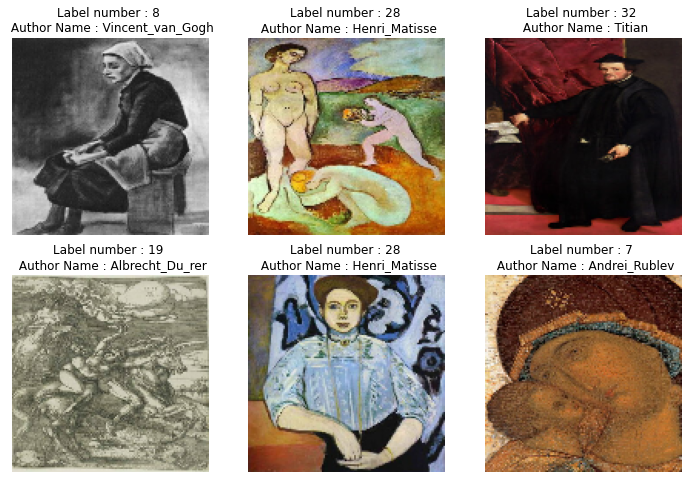

In [ ]:
# 取出Tensor圖片來看看
plt.figure(figsize=(12, 8))
for index,(img,label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2,3,index+1)
    plt.imshow(img)
    plt.title("Label number : {} \n Author Name : {}".format(
        l,
        rev_class_name[l]))
    plt.axis("off")

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [ ]:
# 切割成training data與validation data
train_len = int(0.8*total_len)
val_len = total_len - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ",train_len," val size : ",val_len)

# 添加batch
# todo
batch_size = 64

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train size :  6016  val size :  1504


In [ ]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x,y = trainiter.next()
print("training image batch shape : ",x.shape)
print("training label batch shape : ",y.shape)

training image batch shape :  (64, 128, 128, 3)
training label batch shape :  (64, 50)


## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做fine-tuning，**請自己手動建**。

In [ ]:
input_shape = (IMG_WIDTH,IMG_HEIGHT,3)

# 自訂你的model
model = keras.Sequential(
    [
     keras.Input(shape=input_shape),

     Conv2D(32, kernel_size=(3, 3)),
     BatchNormalization(),
     Activation('relu'),
     MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
     

     Conv2D(64, kernel_size=(3, 3)),
     BatchNormalization(),
     Activation('relu'),
     MaxPooling2D(pool_size=(2, 2),strides=(2,2)),

     Conv2D(128, kernel_size=(3, 3)),
     BatchNormalization(),
     Activation('relu'),
     MaxPooling2D(pool_size=(2, 2),strides=(2,2)),

     Conv2D(256, kernel_size=(3, 3)),
     BatchNormalization(),
     Activation('relu'),
     MaxPooling2D(pool_size=(2, 2),strides=(2,2)),

     Conv2D(512, kernel_size=(3, 3)),
     BatchNormalization(),
     Activation('relu'),
     MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
     
     GlobalAveragePooling2D(),
     #Flatten(),
     Dense(512),
     Activation('relu'),
     Dropout(0.1),
     Dense(num_classes),
     Activation('softmax'),

    ]
)

#adan = Adam(lr=1e-4)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

## 5. 制定訓練計畫

把前處理完的資料輸入進去

In [ ]:
# todo
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


history = model.fit(train_ds, epochs=epochs, class_weight=dict(enumerate(class_weight)), validation_data=val_ds)

Epoch 1/100
94/94 [==============================] - 75s 579ms/step - loss: 67.6103 - accuracy: 0.1720 - val_loss: 4.1088 - val_accuracy: 0.0938
Epoch 2/100
94/94 [==============================] - 56s 527ms/step - loss: 57.4771 - accuracy: 0.2374 - val_loss: 4.3043 - val_accuracy: 0.0452
Epoch 3/100
94/94 [==============================] - 53s 498ms/step - loss: 52.0180 - accuracy: 0.2801 - val_loss: 4.5374 - val_accuracy: 0.0426
Epoch 4/100
94/94 [==============================] - 55s 517ms/step - loss: 47.9013 - accuracy: 0.3200 - val_loss: 4.1287 - val_accuracy: 0.1044
Epoch 5/100
94/94 [==============================] - 54s 510ms/step - loss: 39.6520 - accuracy: 0.3946 - val_loss: 3.5415 - val_accuracy: 0.2227
Epoch 7/100
94/94 [==============================] - 53s 498ms/step - loss: 36.3142 - accuracy: 0.4260 - val_loss: 2.9619 - val_accuracy: 0.2926
Epoch 8/100
94/94 [==============================] - 55s 509ms/step - loss: 32.9724 - accuracy: 0.4578 - val_loss: 3.2634 - val_ac

## 6. 評估模型

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


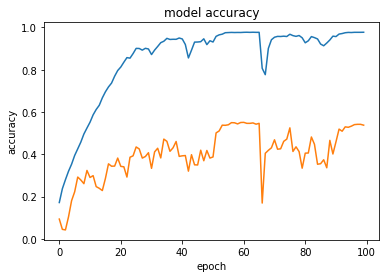

In [ ]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

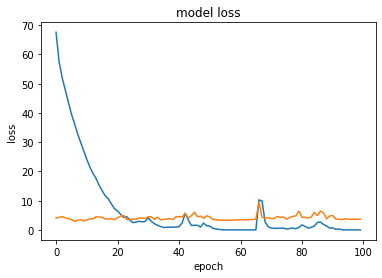

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(batch_size)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

14/14 [==============================] - 3s 34ms/step - loss: 4.3362 - accuracy: 0.5006
Test loss: 4.336187839508057
Test accuracy: 0.5005987882614136


## 7. 做預測 (10分)
* 把前面讀取的圖片拿來丟入模型做預測
* 自己把一張現實中的圖片丟入Model做預測

In [ ]:
def preditAuthor(img):
  # 寫個單圖片模型預測function
  # input : opencv img (height,width,3)
  # output : 某個作家名字 E.g. Claude_Monet
  #
  # 參考步驟:
  # 1. expand img dimension (height,width,3) -> (1,height,width,3)
  # 2. 丟入模型 model.predict
  # 3. 取出softmax後(50,) 取最大值的index作為辨識結果
  # 4. 將辨識結果轉為畫作家名字

  authorName = ""
  img = np.expand_dims(img, axis=0)
  authorNo = np.argmax(model.predict([img]), axis=-1)[0]
  authorName = rev_class_name[authorNo]
  return authorName

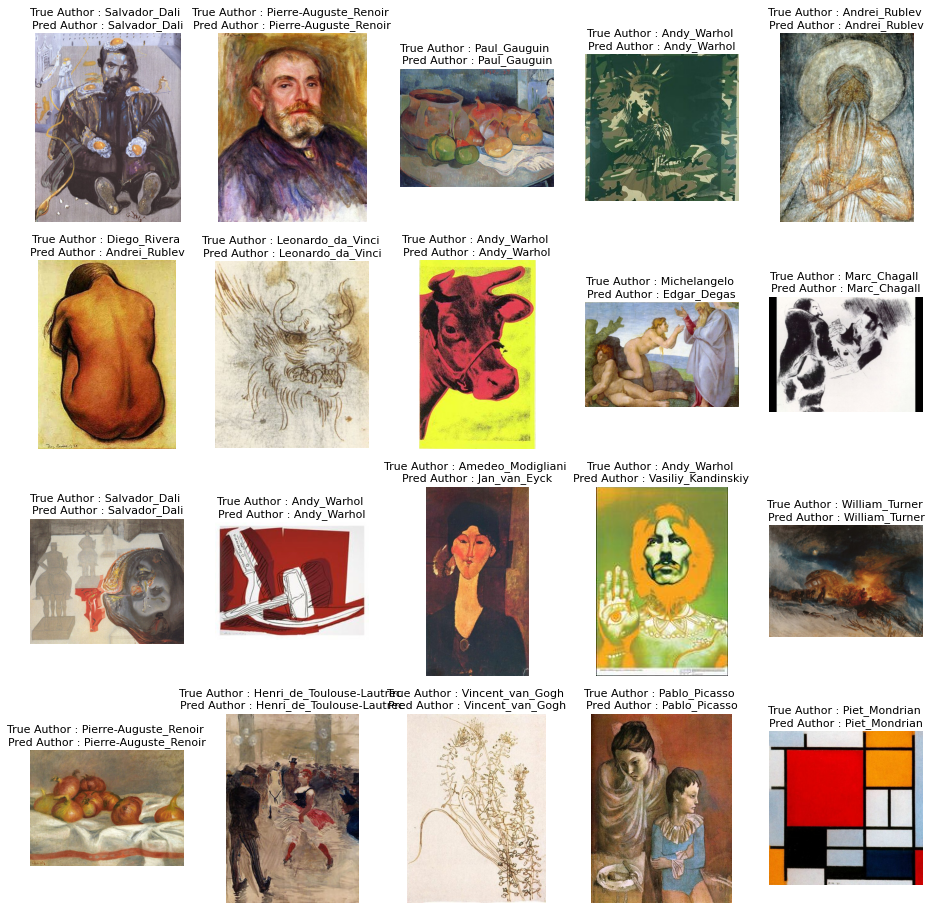

In [ ]:
plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
  imgpath = train_dir+imgName
  img = cv.imread(imgpath)
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  plt.subplot(4,5,index+1)
  plt.axis("off")
  plt.imshow(img)
  img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  img = img / 255.0
  plt.title("True Author : {} \nPred Author : {}".format("_".join(imgName.split("_")[:-1]),preditAuthor(img)),size=11)

* 期望結果
![](https://i.imgur.com/ZEtd7yf.png)

* 自己上傳圖片來試試看模型的效果

In [ ]:
from google.colab import files

def upload_img():
  uploaded = files.upload()
  img_name = list(uploaded.keys())[0]
  img = cv.imread(img_name)
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  plt.imshow(img)
  img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  img = img/255.0
  return img

def eval():
  img = upload_img()
  plt.title("predict author : {}".format(preditAuthor(img)))
  plt.axis("off")
  plt.show()

Saving Red Dead Redemption 2 2022_2_8 上午 12_42_42.png to Red Dead Redemption 2 2022_2_8 上午 12_42_42.png


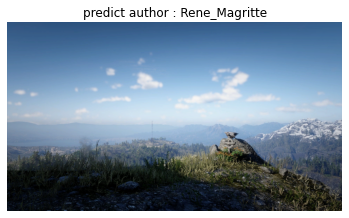

In [ ]:
# 自己上傳一張圖片來試試看
# Demo圖片來自:
# Interview with Cyberpunk 2077 "ponpon shit" producer Yuki Kawamura (https://block.fm/news/cyberpunk2077_uscracks_ENG)
eval()